In [33]:
import os 
import time
import re
import pandas as pd 
import spacy
from datetime import date

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])

# if i scrape NPR The head needs to be on 

In [70]:
def import_existing_citations(existing_set, source):
    if existing_set == True:
        scraped_pages_df = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        scraped_pages_df['url'] = scraped_pages_df['url'].apply(lambda x: x.split('/')[-1])
        scraped_pages = dict(zip(scraped_pages_df['url'], scraped_pages_df['source']))
        
        return scraped_pages # do max_no elsewhere 

    else:
        return None


def start_selenium(source, url):
    options = Options()
    #options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)
    driver.get(url)

    if source == 'FOX':
        #search_archive(driver)
        
        #WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.load-more > a:nth-child(1)'))).click() # get rid of this for media -- or maybe i Have no need at all 
        for i in range(100):
            try:
                driver.find_element(By.CSS_SELECTOR, '.pf-widget-close').click()
            except:
                pass

            try:
                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.load-more > a:nth-child(1)'))))
                WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.load-more > a:nth-child(1)'))).click()
            except Exception as e2: 
                print(e2)
                print('click number ' + str(i))
                pass

        return driver.page_source

    if source == 'NPR':
        scroll_number = 5
        for i in range(1, scroll_number):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)

            try:
                driver.find_element(By.CSS_SELECTOR, '.global-modal__dismiss').click()
            except:
                pass

        return driver.page_source

    if source == 'MSNBC':
        return driver.page_source


def validate_url(url, page_url, source):
    if source == 'FOX':
        if not 'https' in page_url:
            if '/politics/' in page_url or '/media/' in page_url or '/us/':
                page_url = 'https://www.foxnews.com' + page_url            # make sure there are no doubles 
                try:
                    return requests.get(page_url)
                except Exception as e3:
                    print(e3)
                    return None
                    
        elif 'q=coronavirus' in url:
            return requests.get(page_url)
    
    elif source == 'NPR':
        #if not 'ondemand.npr.org' and 'mp3?' in page_url:
        try:
            return requests.get(page_url)
        except Exception as e4:
            print(e4)
            return None

    else:
        try:
            return requests.get(page_url)
        except Exception as e4:
                    print(e4)
                    return None


def export_data(export_path, scraped_pages, out, source, ts):

    if not os.path.exists(export_path + ts):
        os.mkdir(export_path + ts)

    citations = pd.DataFrame(
    {'url': scraped_pages.keys(), 'source': scraped_pages.values()} )

    clean_stuff = pd.DataFrame(citations['source'].tolist(), columns=['source', 'article_id'])

    del(citations['source'])
    citations = pd.concat([citations, clean_stuff], axis=1)

    if not os.path.isfile(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv'):
        citations.to_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv', index = False)
    else:
        old_citations = pd.read_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        citations = pd.concat([citations, old_citations], ignore_index = True)

        citations.to_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv', index = False)

    named_entites = pd.DataFrame(
        {'entity_label': out.keys(), 'entity_text': out.values() } )
            
    named_entites = named_entites.explode('entity_text')

    if not os.path.isfile(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv'):
        named_entites.to_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')
    else:
        old_named_entities = pd.read_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')
        named_entites = pd.concat([named_entites, old_named_entities], ignore_index = True)

        named_entites.to_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv', index = False)


def show_entity_labels():
    print("""
    PERSON:        People's names
    NORP:          Nationalities or religiouse or political groups.
    FAC:           Infrastructure such as buildings, airports, highways, bridges, etc.
    ORG:           Companies, agencies, institutions, etc.
    GPE:           Countries, cities, states.
    LOC:           Non-GPE locations, mountain ranges, bodies of water. 
    PRODUCT:       Objects, vehicles, foods, etc. (Not services.)
    EVENT:         Names of events. Natural disasters, battles, sports events, etc. Coronavirus strains like "omicron" are categorized as events.
    WORK_OF_ART:   Titles of books, songs, etc.
    LAW:           Names of documents made into laws.
    LANGUAGE:      Named languages.
    DATE:          Absolute or relative dates or periods.
    TIME:          Times smaller than a day.
    PERCENT:       Percentage, including "%".
    MONEY:         Monetary values.
    QUANTITY:      Measurements, as of weight or distance.
    ORDINAL:       Terms denoting order, such as "first" or "second."
    CARDINAL:      Numerals that do not fall under another time. 
    """)


# def clean_entities(ls):
#     ls = [str(word) for word in ls]

#     ls = [word.lower() for word in ls]
    
#     ls = [re.sub(r'^the ', '', word) for word in ls]
#     ls = [re.sub(r'\'s', '', word) for word in ls]
#     ls = [re.sub(r's\'', 's', word) for word in ls]
#     ls = [re.sub(r'\`s', '', word) for word in ls]
#     ls = [re.sub(r's\`', '', word) for word in ls]
#     ls = [re.sub(r'’s', '', word) for word in ls]
#     ls = [re.sub(r's’', '', word) for word in ls]
#     ls = [re.sub(r'\"', '', word) for word in ls]

#     ls = [re.sub(r'covid.*19', 'covid-19', word) for word in ls]
#     ls = [re.sub(r'covid.*19 -', 'covid-19', word) for word in ls]

#     remove_image_credits = ['photo', 'getty', 'flickr']
#     ls = [sa for sa in ls if not any(sb in sa for sb in remove_image_credits)]

#     remove_news_outlets = re.compile(r'fox|abc|associated press|^cbs$|reuters|cnn|\bap\b|npr|nbc|buzzfeed|texas tribune|boston globe|bloomberg|vox|washington post|huffpost')
#     # re.match matches the start of the string, while re.search looks for the pattern at any point in the string
#     ls = [sa for sa in ls if not re.search(remove_news_outlets, sa)]

#     ls = [word.strip() for word in ls]
    
#     return ls


def clean_entities(df):
    df['entity_text'] = df['entity_text'].astype(str)

    df['entity_text'] = df['entity_text'].str.lower()

    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r'^the ', '', x))
    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r'\'s', '', x))
    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r's\'', '', x))
    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r'’s', '', x))
    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r's’', '', x))
    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r'\"', '', x))

    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r'covid.*19', 'covid-19', x))
    df['entity_text'] = df['entity_text'].apply(lambda x: re.sub(r'covid.*19 -', 'covid-19', x))

    remove_news_outlets = re.compile(r'fox|llc|abc|associated press|^cbs$|reuters|cnn|\bap\b|npr|nbc|buzzfeed|tribune|boston globe|bloomberg|vox|washington post|huffpost|new york post|new york times|usa today')
    f = df['entity_text'].str.contains(remove_news_outlets)
    df = df[~f]

    remove_image_credits = re.compile(r'photo|getty|flickr|istock|^afp$')
    f = df['entity_text'].str.contains(remove_image_credits)
    df = df[~f]

    remove_junk = re.compile(r'nan|file|^quote$|^quotes$')
    f = df['entity_text'].str.contains(remove_junk)
    df = df[~f]

    remove_fox_ads = re.compile(r'factset|mutual fund|refinitive|^app$')
    f = df['entity_text'].str.contains(remove_fox_ads)
    df = df[~f]

    glyphs = re.compile(r'�')
    f = df['entity_text'].str.contains(glyphs)
    df = df[~f]
    
    df['entity_text'] = df['entity_text'].str.strip()

    df = df.drop(df[df['entity_text'].str.len() < 2].index)

    return df


def extract_named_entities(requests_url):
    ne_dictionary = {}

    if requests_url is not None:
        try:
            page_content = BeautifulSoup(requests_url.text, 'html.parser')
            
            for paragraph in page_content.findAll('p'):
                paragraph = list(paragraph.stripped_strings)
                
                for sentence in paragraph:
                    sentence = nlp(sentence)
                    
                    for entity in sentence.ents:
                        if not entity.label_ in ne_dictionary.keys():
                            ne_dictionary[entity.label_] = [entity.text]
                        else:
                            ne_dictionary[entity.label_].append(entity.text)
        
        except Exception as e5:
            print(e5)
    
    return ne_dictionary


def to_upper(row):
    if len(row) <= 3:
        return row.upper()
    else:
        return row

def title_case(row):
    if len(row) > 3:
        return row.title()
    else:
        return row

def correct_case(df):
    df['entity_text'] = df['entity_text'].apply(to_upper)
    df['entity_text'] = df['entity_text'].apply(title_case)

    return df

def correct_entity_labels(named_entites):
    # d- and r- are recategorized to represent democrat or republican

    coronavirus = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask|\bncov\b', re.IGNORECASE)
    events = re.compile(r'twitter .*|mandate|^tts$', re.IGNORECASE)
    vaccines = re.compile(r'pfizer|moderna|johnson', re.IGNORECASE)
    people = re.compile(r'warren|trump|psaki|palin|fauci|santa claus|desantis|cuomo|newsom|de blasio|biden|horak|mayorkas|michelle|kilgore|murphy|walensky', re.IGNORECASE)
    organizations = re.compile(r'^d-|^r-|refinitiv lipper|england patriots|scarlet.*knights|astros|task(.*)force|democrat|republican|delta air', re.IGNORECASE) 
    gpe_locations = re.compile(r'eswatini|seattle|america| u\.s\.|beijing|louisiana|michigan', re.IGNORECASE)

    products = re.compile(r'hunger games', re.IGNORECASE)

    named_entites['entity_text'] = named_entites['entity_text'].str.lower()
    named_entites['entity_text'] = named_entites['entity_text'].astype(str)

    named_entites['entity_label'] = named_entites.apply(lambda row: 'EVENT' if coronavirus.search(row['entity_text']) else row['entity_label'] , axis=1)
    named_entites['entity_label'] = named_entites.apply(lambda row: 'ORG' if organizations.search(row['entity_text']) else row['entity_label'] , axis=1)
    named_entites['entity_label'] = named_entites.apply(lambda row: 'ORG' if vaccines.search(row['entity_text']) else row['entity_label'] , axis=1)
    named_entites['entity_label'] = named_entites.apply(lambda row: 'EVENT' if events.search(row['entity_text']) else row['entity_label'] , axis=1)
    named_entites['entity_label'] = named_entites.apply(lambda row: 'PERSON' if people.search(row['entity_text']) else row['entity_label'] , axis=1)
    named_entites['entity_label'] = named_entites.apply(lambda row: 'GPE' if gpe_locations.search(row['entity_text']) else row['entity_label'] , axis=1)

    named_entites['entity_label'] = named_entites.apply(lambda row: 'PRODUCT' if products.search(row['entity_text']) else row['entity_label'] , axis=1)

    return named_entites


def count_words(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    
    return ngrams_dict


def time_stamp():
    today = date.today()
    d_today = today.strftime("%m-%d-%Y")

    return d_today

def barplot_entities(df, ts, filter, source):
    df = correct_entity_labels(df)
    df = clean_entities(df)

    df['count'] = df.groupby('entity_text')['entity_text'].transform('count')
 
    df['proportion'] = find_proportion(df)

    df = df[df['entity_label'] == filter].copy()

    df = df.drop_duplicates()

    df = correct_case(df)
    

    #df = df['entity_text'].tolist()
    #df = clean_entities(df)
    #df = count_words(df)
    #df = pd.DataFrame(
    #{'word': df.keys(), 'count': df.values() } )

    
    df.sort_values(by = ['proportion'], inplace = True, ascending = False)

    #df.to_csv('/home/projects/entascope/fox.csv')
    df = df[1:30].copy()
    df.sort_values(by = ['proportion'], inplace = True, ascending = True)

    #import plotly.graph_objects as go

    #fig = go.Figure(go.Bar(
    #    x=df['proportion'],
    #    y=df['entity_text'],
    #    orientation='h'))

    #fig.update_layout(
    #    autosize=False,
    #    width=800,
    #    height=1000,
        
        #title = {
        #    'text': 'Manually Specified Labels',
        #    'xanchor' : 'center',
        #    'yanchor' : 'top' } 
            
    #        )


    plt.barh(df['entity_text'], df['proportion'])
    plt.ylabel(filter + ' Name')

    plt.margins(y=.005)

    plt.title('Proportion of ' + filter + ' tagged enitites in ' + source + ' News Articles about Covid-19' )

    plt.rcParams["figure.figsize"] = [6,8]

    plt.savefig('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + source + '_' + filter + '.pdf')
    plt.show()
    plt.close()

    #fig.show()
    #fig.write_image('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + source + '_' + filter + '.pdf')

def find_proportion(df):
    return df['count'] / df['count'].sum() * 100


def scraper(url, response, source, ts, **kwargs):

    keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask', re.IGNORECASE)

    start_page = BeautifulSoup(response, 'html.parser')

    recorded_sites = {}
    
    if kwargs.get('existing_set') == True:
        scraped_pages_df = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        scraped_pages_df['url'] = scraped_pages_df['url'].apply(lambda x: x.split('/')[-1])

        scraped_pages = dict(zip(scraped_pages_df['url'], scraped_pages_df['source']))
        
        max_no = scraped_pages_df['article_id'].max()

    else:
        scraped_pages = {}
        max_no = None

    

    #scraped_pages = import_existing_citations(source, citaitons)
    #if scraped_pages is not None:
    #    max_no = '' #get article ID max
    #else:
    #    max_no = None


    out = {}

    article = 0
    cycle = 0
    for link in start_page.findAll('a'):

        if 'href' in str(link):
            page_url = link['href']

            if keyword.search(page_url):

                if not page_url.split('/')[-1] in scraped_pages.keys():

                    ###### I can probably get rid fo recorded pages dict now that I have a method for splitting url
                    # and then I can just record the vlidated version od scraped pages  
                    cycle = cycle + 1
                    if max_no is not None:
                        if cycle == 1:
                            article = max_no + 1
                        else:
                            article = article + 1
                    else:
                        article = article + 1

                    if source == 'FOX':
                        if not 'https' in page_url: 
                            record = 'https://www.foxnews.com' + page_url  
                            recorded_sites[record] = [source, article] 
                        else: 
                            recorded_sites[page_url] = [source, article]
                    else: 
                        recorded_sites[page_url] = [source, article]

                    ### this si citations 
                    
                    scraped_pages[page_url] = source
                    
                    # scraped_pages[page_url] = [source, article]
                
                # make a distinction between citations and named entity extraction 

                    next_page = validate_url(url, page_url, source) 

                    di = extract_named_entities(next_page)
                    
                    for key in di.keys():
                        if key in di: 
                            out.setdefault(key, []).extend(di[key])                        


                   # next_page = requests.get(page_url)
                    # if next_page is not None: # should be passed requests.get(url)
                    #     try:
                    #          page_content = BeautifulSoup(next_page.text, 'html.parser')

                    #           #for every paragraph in the page content (denoted by the "p" anchor)
                             
                    #          for paragraph in page_content.findAll('p'):
                    #              paragraph = list(paragraph.stripped_strings)

                    #              for sentence in paragraph: 
                    #                  try:
                    #                      sentence = nlp(sentence)

                    #                      for entity in sentence.ents:
                    #                          if not entity.label_ in out.keys():
                    #                              out[entity.label_] = [entity.text]
                    #                          else:
                    #                              out[entity.label_].append(entity.text)
                    #                  except Exception as e1:
                    #                      print(e1)

                    #     except Exception as e5:
                    #         print(e5)

                                
                                            
                    time.sleep(1)
 
   
        else:
            pass

    #start_page.quit() # will this turn off driver?
    export_data('/home/stephbuon/projects/entascope/scraped_pages/', recorded_sites, out, source, ts)

# class news_scraper.dynamic_load()

def scrape_pages_load_more(url, source, ts, **kwargs): # dynamic_load_scraper():

    existing_set = kwargs.get('existing_set', None)
    
    # selenium is used to activate triggers like "show more" buttons
    # the triggered website is then assigned to response (instead of using requests)
    response = start_selenium(source, url)
    #response = requests.get(url)

    scraper(url, response, source, ts, existing_set = existing_set)


def scrape_pages_multi_page(url, source, ts): # scrape_pages_multi_page():

    keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask', re.IGNORECASE)
    
    options = Options()
    #options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)

    for i in range(5): 
        if source == 'KRISTV':
            url_w_page = url + str(i)

            driver.get(url_w_page)
            
            try:
                try:
                    driver.find_element(By.CSS_SELECTOR, '.MAD_INVIEW_CLOSE').click()
                except:
                    pass

                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, .5).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "a.List"))))
                WebDriverWait(driver, .5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a.List"))).click()

                scraper(driver.page_source, source, ts)
                
            except Exception as e: 
                print(e)
                pass  

In [80]:
from selenium.webdriver.support.ui import Select

def search_archive(driver):

    select = Select(driver.find_element(By.CSS_SELECTOR, 'div.month:nth-child(2) > ul:nth-child(2)'))
    
    select.select_by_value('1')

In [82]:
ts = time_stamp()
scrape_pages_load_more('https://www.npr.org/sections/news/archive', 'NPR', ts)#, existing_set = True)

# the scroll page for msbnc: https://www.msnbc.com/opinion/columnists


#https://www.foxnews.com/media # do the hash out 
#https://www.foxnews.com/category/us/economy





# https://www.npr.org/sections/news/archive
# Dec 27 -- night
# July 31
# 440 scrolls 
# 73 min

# https://www.foxnews.com/lifestyle
# Dec 27 -- evening
# August 3rd
# 220 clicks
# ~10 minutes 

# https://www.foxnews.com/us
# Dec 27 -- evening
# August 3rd
# 400 clicks 
# ~30 minutes 

# https://www.foxnews.com/opinion 
# Dec 27 -- noon
# August 3rd
# 92 clicks
# ~9 minutes

# https://www.foxnews.com/politics
# Dec 27 -- noon 
# August 3rd 
# 400 clicks
# ~43 minutes

/tmp/ipykernel_40374/1709425380.py:4: DeprecationWarning:

executable_path has been deprecated, please pass in a Service object



KeyboardInterrupt: 

In [82]:
#def log_urls(source, url):
#    if source == 'FOX':
#        if 'q=coronavirus' in url:
#            pass
#        elif 

In [84]:
ts = time_stamp()
scrape_pages_multi_page('https://www.kristv.com/?00000169-7dca-d05d-ab6f-7fdbf8990001-page=', 'KRISTV', ts)
# its not under us, its under politics 
#scrape_pages('https://www.foxnews.com/politics', 'FOX', ts)

/tmp/ipykernel_5160/1781366942.py:348: DeprecationWarning:

executable_path has been deprecated, please pass in a Service object



Message: Failed to decode response from marionette



InvalidSessionIdException: Message: Tried to run command without establishing a connection


In [ ]:
ts = '12-27-2021'
fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_FOX_' + ts +'.csv')
#msnbc_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_MSNBC_' + ts +'.csv')
#npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_NPR_' + ts +'.csv')

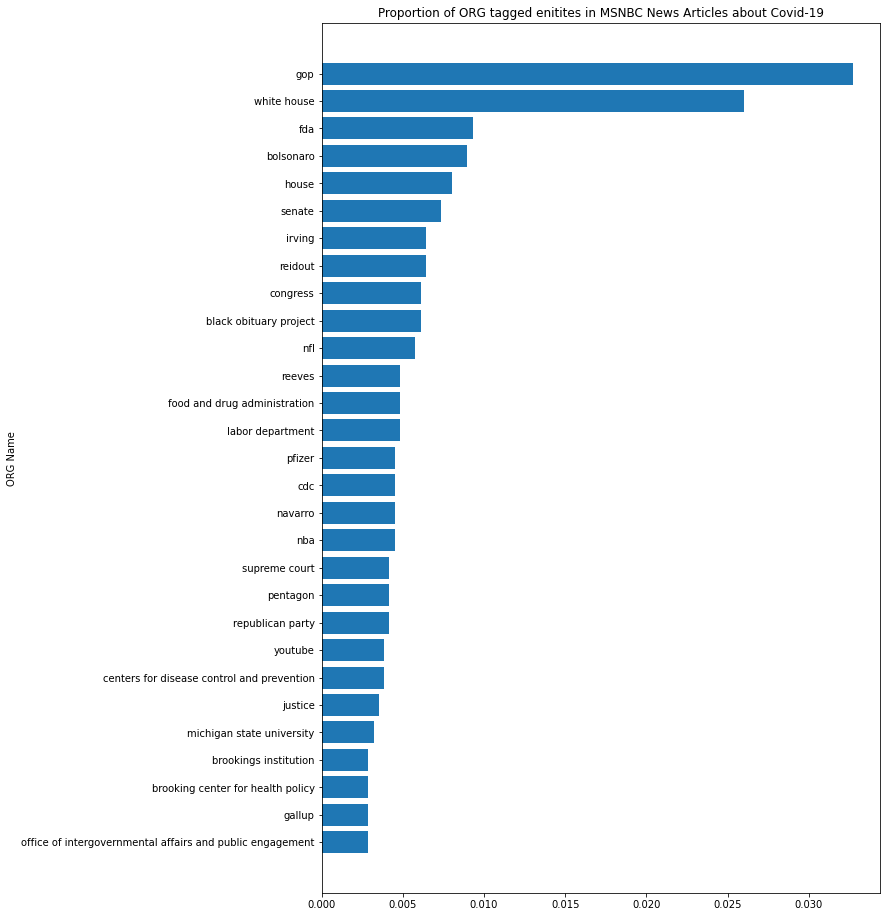

In [165]:
msnbc_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_MSNBC_' + ts +'.csv')

barplot_entities(msnbc_ne, ts, 'PRODUCT', 'MSNBC') # cut off the 's 

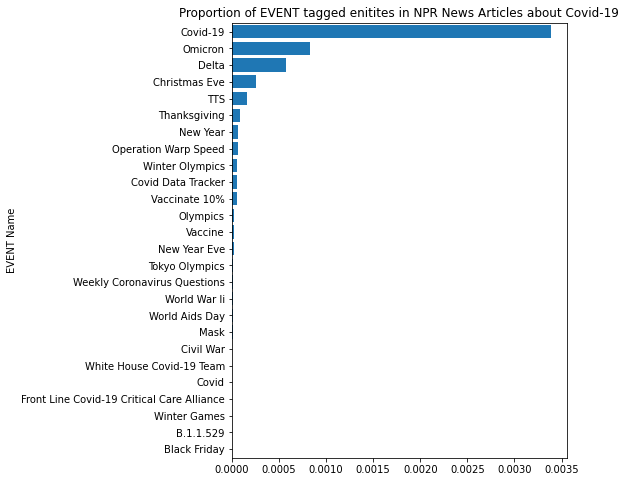

In [72]:
npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + '12-27-2021' + '/' + 'named_entities_NPR_' + '12-27-2021' +'.csv')
barplot_entities(npr_ne, ts, 'EVENT', 'NPR')

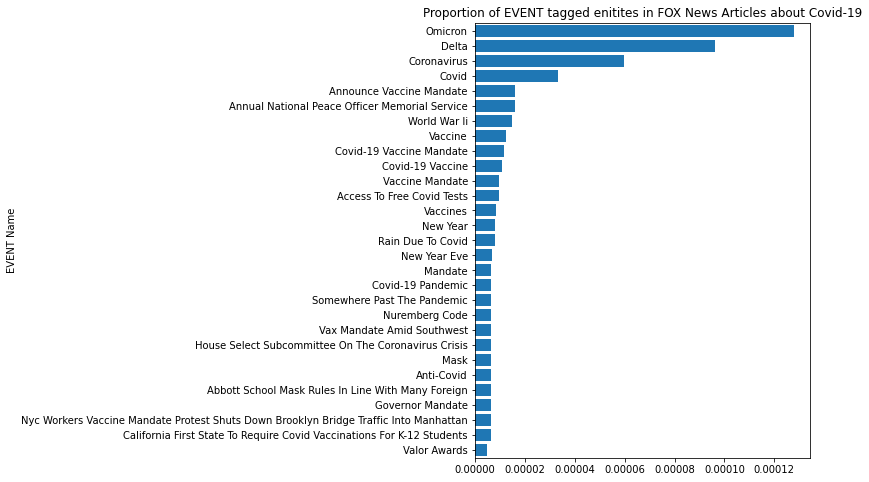

In [71]:
entities = ['EVENT', 'LAW', 'ORG']
fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/12-27-2021/debug_FOX_named_entities.csv')

barplot_entities(fox_ne, ts, 'EVENT', 'FOX')
